<a href="https://colab.research.google.com/github/yucellgereklioglu/datasciencework/blob/main/Predicting_Optimal_Fertilizers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, Image

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [2]:
data=pd.read_csv('/content/train.csv')
test=pd.read_csv('/content/test.csv')
subm=pd.read_csv('/content/sample_submission.csv')

In [3]:
le=LabelEncoder()
data['Soil Type']=le.fit_transform(data['Soil Type'])
data['Crop Type']=le.fit_transform(data['Crop Type'])

In [6]:
data['Fertilizer Name'] = le.fit_transform(data['Fertilizer Name'])
display(data.head())

,id,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,0,37,70,36,1,9,36.0,4.0,5.0,4
1,1,27,69,65,4,4,30.0,6.0,18.0,4
2,2,29,63,32,4,4,24.0,12.0,16.0,2
3,3,35,62,54,4,0,39.0,12.0,4.0,0
4,4,35,58,43,3,7,37.0,2.0,16.0,5


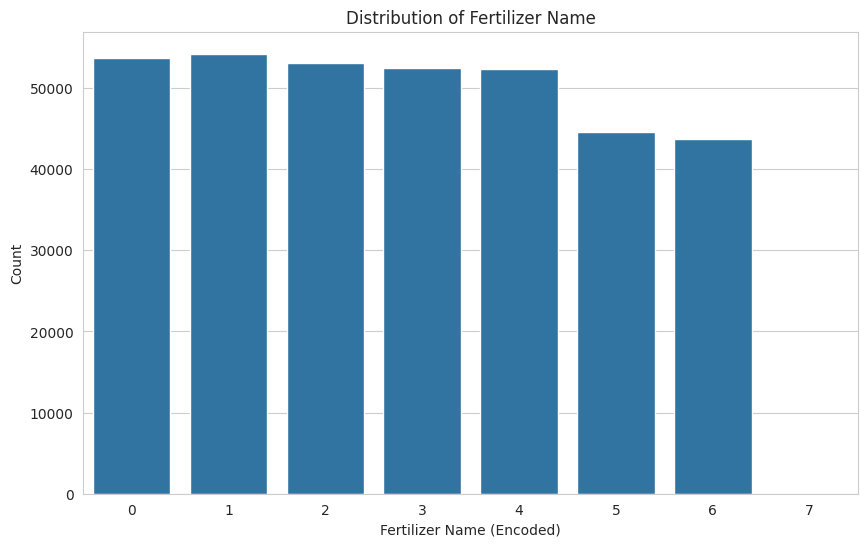

,Fertilizer Name
count,354129.000000
mean,2.858817
std,1.966899
min,0.000000
25%,1.000000
50%,3.000000
75%,4.000000
max,7.000000
mode,1.000000


In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Fertilizer Name')
plt.title('Distribution of Fertilizer Name')
plt.xlabel('Fertilizer Name (Encoded)')
plt.ylabel('Count')
plt.show()
description = data['Fertilizer Name'].describe()
mode_value = data['Fertilizer Name'].mode()[0]
description['mode'] = mode_value
display(description)

In [9]:
X = data.drop('Fertilizer Name', axis=1)
y = data['Fertilizer Name']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [11]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y_train_encoded = lb.fit_transform(y_train)
y_test_encoded = lb.transform(y_test)


Now that the `catboost` library is installed, you can run the cell with the model training code again.

In [19]:
# Impute missing values with the mean in training and testing sets
for col in ['Nitrogen', 'Potassium', 'Phosphorous']:
    mean_val = X_train[col].mean()
    X_train[col].fillna(mean_val, inplace=True)
    X_test[col].fillna(mean_val, inplace=True)

print("Missing values in X_train after imputation:")
print(X_train[['Nitrogen', 'Potassium', 'Phosphorous']].isnull().sum())

print("\nMissing values in X_test after imputation:")
print(X_test[['Nitrogen', 'Potassium', 'Phosphorous']].isnull().sum())

Missing values in X_train after imputation:
Nitrogen       0
Potassium      0
Phosphorous    0
dtype: int64

Missing values in X_test after imputation:
Nitrogen       0
Potassium      0
Phosphorous    0
dtype: int64


In [33]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=100,
    depth=2,
    learning_rate=0.02,
    early_stopping_rounds=30,
    loss_function="MultiClass",
    eval_metric="MultiClass",
    l2_leaf_reg=0.15,
    bootstrap_type="Bayesian",
    use_best_model=True,
    bagging_temperature=0.25,
    random_strength=0.5,
    random_state=42,
    border_count=62,
    verbose=100,
    cat_features=['Soil Type', 'Crop Type']
)

model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    use_best_model=True,
    verbose=100
)

0:	learn: 2.0764547	test: 2.0764585	best: 2.0764585 (0)	total: 960ms	remaining: 1m 35s
99:	learn: 1.9588501	test: 1.9590731	best: 1.9590731 (99)	total: 1m 26s	remaining: 0us

bestTest = 1.959073092
bestIteration = 99



In [24]:
y_pred=model.predict(X_test)
y_probabilty=model.predict_proba(X_test)


Classification Report:
              precision    recall  f1-score   support

           0       0.19      0.20      0.20     10884
           1       0.18      0.26      0.21     10689
           2       0.19      0.22      0.20     10727
           3       0.18      0.19      0.18     10464
           4       0.17      0.19      0.18     10402
           5       0.17      0.10      0.12      8910
           6       0.18      0.08      0.11      8750

    accuracy                           0.18     70826
   macro avg       0.18      0.18      0.17     70826
weighted avg       0.18      0.18      0.17     70826



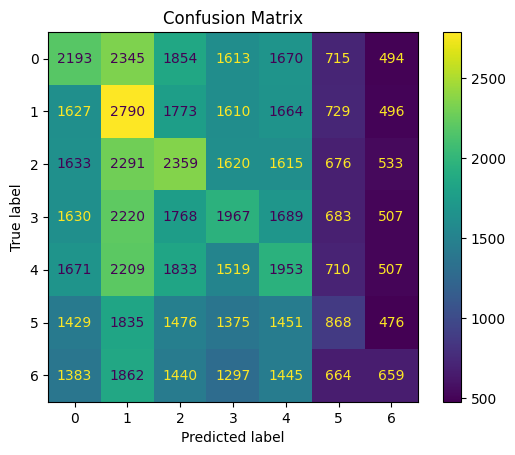

Accuracy Score: 0.1805692824668907
Precision (weighted): 0.1799905465408807
Recall (weighted): 0.1805692824668907
F1 Score (weighted): 0.1749182838624017


In [34]:
print("Classification Report:")
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='viridis')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy}")
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Precision (weighted): {precision}")
print(f"Recall (weighted): {recall}")
print(f"F1 Score (weighted): {f1}")

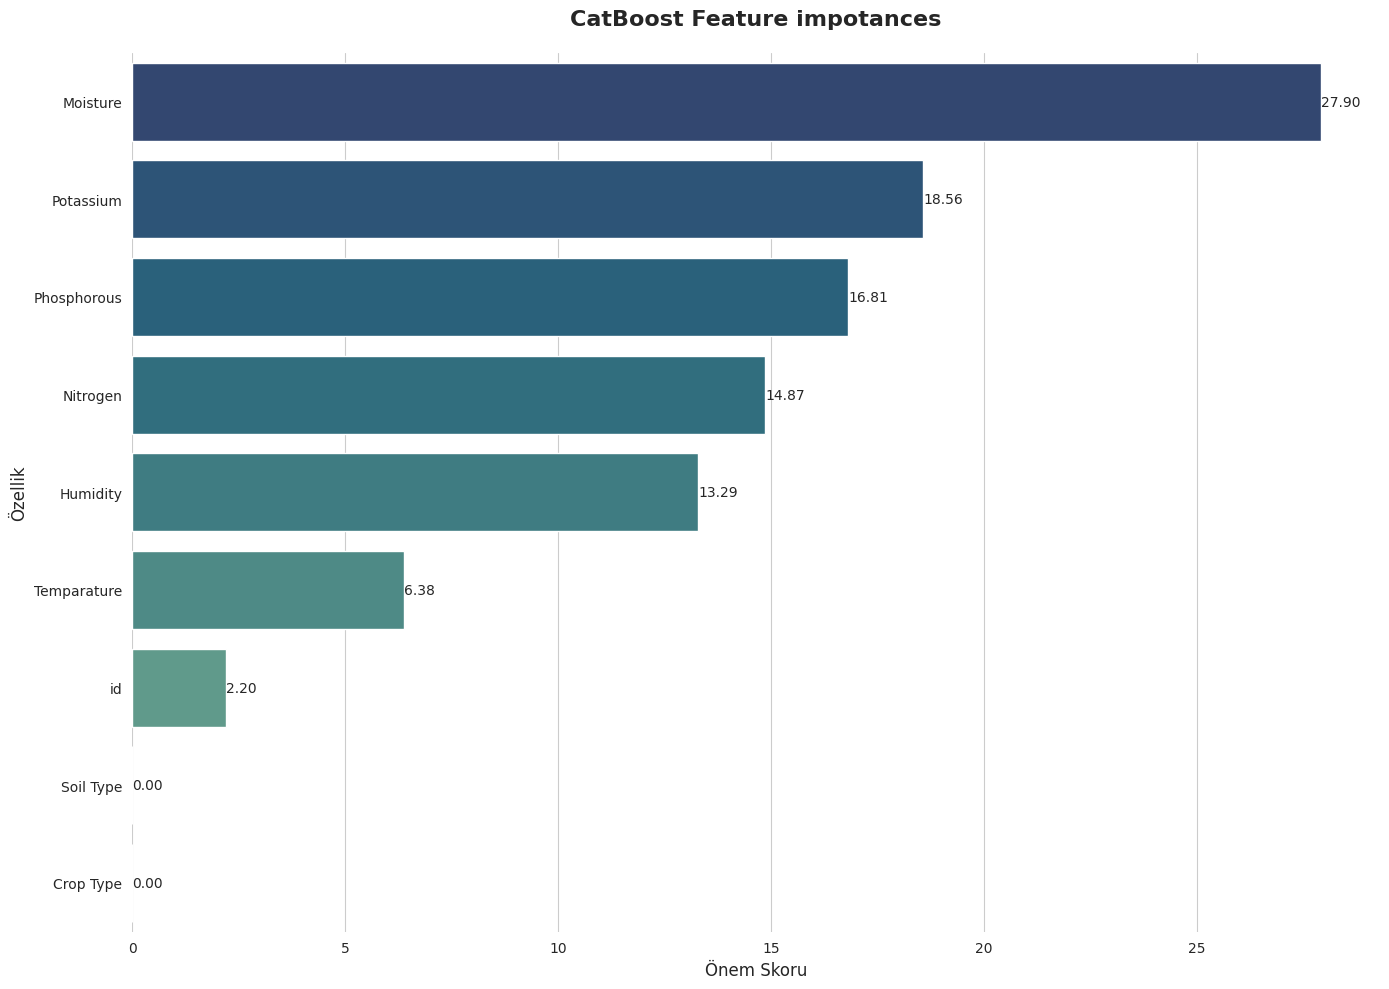

,Feature Id,Importances
0,Moisture,27.897281
1,Potassium,18.563954
2,Phosphorous,16.806093
3,Nitrogen,14.868697
4,Humidity,13.285513
5,Temparature,6.379172
6,id,2.199289
7,Soil Type,0.000000
8,Crop Type,0.000000


In [39]:
feature_importances = model.get_feature_importance(prettified=True)
feature_importances = feature_importances.sort_values(by='Importances', ascending=False)
sns.set_style("whitegrid")
plt.figure(figsize=(14, 10))
barplot = sns.barplot(
    x='Importances',
    y='Feature Id',
    data=feature_importances,
    palette='crest_r'
)
sns.despine(left=True, bottom=True)
plt.title('CatBoost Feature impotances', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Önem Skoru', fontsize=12)
plt.ylabel('Özellik', fontsize=12)
for p in barplot.patches:
    width = p.get_width()
    plt.text(width + 0.01,
             p.get_y() + p.get_height() / 2,
             f'{width:.2f}',
             va='center')
plt.tight_layout()
plt.show()
display(feature_importances)

/tmp/ipython-input-37-3219020682.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', n_classes)


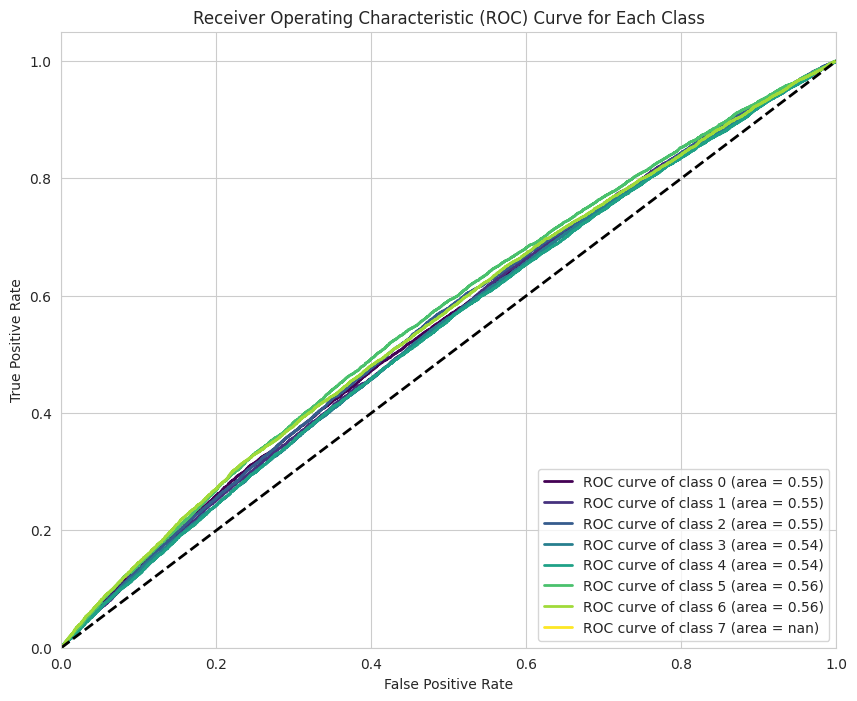

In [37]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
y_test_bin = label_binarize(y_test, classes=model.classes_)
n_classes = y_test_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_probabilty[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('viridis', n_classes)
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors(i), lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Each Class')
plt.legend(loc="lower right")
plt.show()